### The Put-Call Ratio of a stock is a time-dependent parameter, for which a Time-series prediction model is used to predict Put-Call Ratio for 16th August,2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel (r'Test_dataset.xlsx',sheet_name='Put-Call_TS')
df.head()

,Stock Index,2020-08-10 00:00:00,2020-08-11 00:00:00,2020-08-12 00:00:00,2020-08-13 00:00:00,2020-08-14 00:00:00,2020-08-15 00:00:00
0,AC3235,0.80,0.660,0.77240,0.983224,0.901211,0.898368
1,AC3236,0.86,0.732,0.85448,1.086645,1.017042,1.029258
2,AC3237,0.93,0.816,0.95024,1.207302,NaN,1.181962
3,AC3238,1.09,1.008,1.16912,1.483091,1.461062,1.531000
4,AC3239,NaN,1.104,1.27856,1.620986,1.615504,1.705519


In [4]:
df = df.set_index('Stock Index')
df.head()

,2020-08-10 00:00:00,2020-08-11 00:00:00,2020-08-12 00:00:00,2020-08-13 00:00:00,2020-08-14 00:00:00,2020-08-15 00:00:00
Stock Index,,,,,,
AC3235,0.80,0.660,0.77240,0.983224,0.901211,0.898368
AC3236,0.86,0.732,0.85448,1.086645,1.017042,1.029258
AC3237,0.93,0.816,0.95024,1.207302,NaN,1.181962
AC3238,1.09,1.008,1.16912,1.483091,1.461062,1.531000
AC3239,NaN,1.104,1.27856,1.620986,1.615504,1.705519


In [5]:
df.isnull().any()

2020-08-10    True
2020-08-11    True
2020-08-12    True
2020-08-13    True
2020-08-14    True
2020-08-15    True
dtype: bool

In [6]:
df=df.fillna(df.mean())

In [7]:
df.isnull().any()

2020-08-10    False
2020-08-11    False
2020-08-12    False
2020-08-13    False
2020-08-14    False
2020-08-15    False
dtype: bool

In [8]:
df.dtypes

2020-08-10    float64
2020-08-11    float64
2020-08-12    float64
2020-08-13    float64
2020-08-14    float64
2020-08-15    float64
dtype: object

### Transposing the data to apply the model for each date

In [9]:
df = df.T
df.head(10)

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-10 00:00:00,0.800000,0.860000,0.930000,1.090000,0.938828,0.938828,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
2020-08-11 00:00:00,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
2020-08-12 00:00:00,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,0.960627,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
2020-08-13 00:00:00,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
2020-08-14 00:00:00,0.901211,1.017042,1.165254,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.165254,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380
2020-08-15 00:00:00,0.898368,1.029258,1.181962,1.531000,1.705519,1.792779,1.836409,1.334666,1.334666,1.487370,...,1.029258,0.462070,0.789294,1.312851,1.356481,1.029258,0.549330,0.614775,0.876553,0.767479


In [10]:
df.dtypes

Stock Index
AC3235    float64
AC3236    float64
AC3237    float64
AC3238    float64
AC3239    float64
           ...   
AD2734    float64
AD2735    float64
AD2736    float64
AD2737    float64
AD2738    float64
Length: 3331, dtype: object

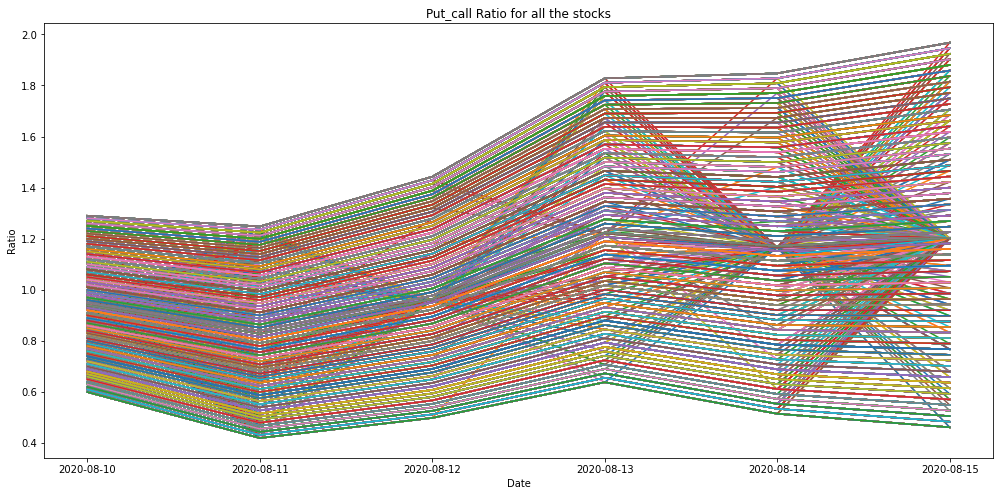

In [11]:
plt.figure(figsize=(17, 8))
plt.plot(df)
plt.title('Put_call Ratio for all the stocks')
plt.ylabel('Ratio')
plt.xlabel('Date')
plt.show()

## Forecast of the put-call ratio for 16th August

# Considering the problem as multivariated time series(MTS) problem, the model used for the forecast is Vector Auto Regression (VAR).

In [13]:
from statsmodels.tsa.vector_ar.var_model import VAR
#make final predictions
model = VAR(endog=df)
model_fit = model.fit()
predicted_putcall = model_fit.forecast(model_fit.y, steps=1)
print(predicted_putcall)
predicted_putcall.shape

[[1.12969736 1.2533827  1.3923306  ... 0.86171245 1.10908313 1.00601202]]


(1, 3331)

In [14]:
#predicted_putcall.shape
model_fit.y[5]


array([0.89836829, 1.02925766, 1.18196192, ..., 0.61477467, 0.8765534 ,
       0.76747893])

# Model for predicting the put-call ratio probability on 16th August

In [15]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [16]:
df1 = pd.read_excel (r'Train_dataset.xlsx')
df1.head()

,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,P/B Ratio,Stock Price
0,AA1,NYSE,Real Estate,700.29,12765.84,32.38,45.35,1208599.0,5.05,-0.43,0.0520,1.0,0.61,9.20,156.987852
1,AA2,NYSE,Information Tech,214.52,12765.84,33.25,170.56,13753356.0,3.10,0.23,0.0164,1.0,NaN,6.91,560.859622
2,AA3,NYSE,Information Tech,943.42,12765.84,88.27,143.58,6892003.0,7.70,0.23,0.0396,1.0,NaN,6.09,1279.732874
3,AA4,BSE,Materials,828.13,38182.08,73.66,151.76,8316793.0,4.80,0.03,0.0431,74.9,1.11,5.60,1121.787632
4,AA5,S&P 500,Real Estate,NaN,3351.28,23.79,NaN,3943312.0,8.06,-0.43,0.0244,1.0,1.07,9.46,382.962534


In [17]:
df2=pd.read_excel (r'Test_dataset.xlsx')
df2.head()

,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,P/B Ratio
0,AC3235,NSE,Materials,53.30,11270.15,44.59,185.09,12067855.0,2.78,0.03,0.0330,74.9,0.80,4.66
1,AC3236,JSE,Energy,749.34,55722.00,74.20,34.01,6172474.0,6.78,0.11,0.0464,17.7,0.86,6.11
2,AC3237,S&P 500,Information Tech,567.75,3351.28,88.41,177.40,17472488.0,4.36,0.23,0.0401,1.0,0.93,4.99
3,AC3238,NSE,Healthcare,646.78,11270.15,79.36,105.44,15553159.0,2.77,0.78,0.0187,74.9,1.09,1.26
4,AC3239,NYSE,Materials,380.33,12765.84,19.90,139.40,12525784.0,5.93,0.03,0.0261,1.0,NaN,6.18


In [18]:
df1.isna().sum()

Stock Index               0
Index                     0
Industry                  0
VWAP                     38
General Index            62
NAV                      61
P/E Ratio               234
Volumes Traded          268
Inventory Turnover      399
Covid Impact (Beta)     376
Tracking Error           71
Dollar Exchange Rate     77
Put-Call Ratio           85
P/B Ratio                25
Stock Price               0
dtype: int64

In [19]:
train_df = df1
test_df = df2

In [20]:
test_df.shape

(3331, 14)

In [21]:
test_df['Put-Call Ratio'] = predicted_putcall.T
test_df['Put-Call Ratio'].head()

0    1.129697
1    1.253383
2    1.392331
3    1.727510
4    1.892424
Name: Put-Call Ratio, dtype: float64

In [22]:
train_df = train_df.drop(['Stock Index'], axis = 1) 
train_df.head()

,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,P/B Ratio,Stock Price
0,NYSE,Real Estate,700.29,12765.84,32.38,45.35,1208599.0,5.05,-0.43,0.0520,1.0,0.61,9.20,156.987852
1,NYSE,Information Tech,214.52,12765.84,33.25,170.56,13753356.0,3.10,0.23,0.0164,1.0,NaN,6.91,560.859622
2,NYSE,Information Tech,943.42,12765.84,88.27,143.58,6892003.0,7.70,0.23,0.0396,1.0,NaN,6.09,1279.732874
3,BSE,Materials,828.13,38182.08,73.66,151.76,8316793.0,4.80,0.03,0.0431,74.9,1.11,5.60,1121.787632
4,S&P 500,Real Estate,NaN,3351.28,23.79,NaN,3943312.0,8.06,-0.43,0.0244,1.0,1.07,9.46,382.962534


In [23]:
train_df.isnull().any()

Index                   False
Industry                False
VWAP                     True
General Index            True
NAV                      True
P/E Ratio                True
Volumes Traded           True
Inventory Turnover       True
Covid Impact (Beta)      True
Tracking Error           True
Dollar Exchange Rate     True
Put-Call Ratio           True
P/B Ratio                True
Stock Price             False
dtype: bool

In [24]:
train_df['VWAP'].fillna((train_df['VWAP'].mean()),inplace=True)
train_df['General Index'].fillna((train_df['General Index'].mean()),inplace=True)
train_df['NAV'].fillna((train_df['NAV'].mean()),inplace=True)
train_df['P/E Ratio'].fillna((train_df['P/E Ratio'].mean()),inplace=True)
train_df['Volumes Traded'].fillna((train_df['Volumes Traded'].mean()),inplace=True)
train_df['Inventory Turnover'].fillna((train_df['Inventory Turnover'].mean()),inplace=True)
train_df['Covid Impact (Beta)'].fillna((train_df['Covid Impact (Beta)'].mean()),inplace=True)
train_df['Tracking Error'].fillna((train_df['Tracking Error'].mean()),inplace=True)
train_df['Dollar Exchange Rate'].fillna((train_df['Dollar Exchange Rate'].mean()),inplace=True)
train_df['Put-Call Ratio'].fillna((train_df['Put-Call Ratio'].mean()),inplace=True)
train_df['P/B Ratio'].fillna((train_df['P/B Ratio'].mean()),inplace=True)








In [25]:
test_df.isnull().any()

Stock Index             False
Index                   False
Industry                False
VWAP                     True
General Index            True
NAV                      True
P/E Ratio                True
Volumes Traded           True
Inventory Turnover       True
Covid Impact (Beta)      True
Tracking Error           True
Dollar Exchange Rate     True
Put-Call Ratio          False
P/B Ratio                True
dtype: bool

In [26]:
test_df['VWAP'].fillna((test_df['VWAP'].mean()),inplace=True)
test_df['General Index'].fillna((test_df['General Index'].mean()),inplace=True)
test_df['NAV'].fillna((test_df['NAV'].mean()),inplace=True)
test_df['P/E Ratio'].fillna((test_df['P/E Ratio'].mean()),inplace=True)
test_df['Volumes Traded'].fillna((test_df['Volumes Traded'].mean()),inplace=True)
test_df['Inventory Turnover'].fillna((test_df['Inventory Turnover'].mean()),inplace=True)
test_df['Covid Impact (Beta)'].fillna((test_df['Covid Impact (Beta)'].mean()),inplace=True)
test_df['Tracking Error'].fillna((test_df['Tracking Error'].mean()),inplace=True)
test_df['Dollar Exchange Rate'].fillna((test_df['Dollar Exchange Rate'].mean()),inplace=True)
test_df['Put-Call Ratio'].fillna((test_df['Put-Call Ratio'].mean()),inplace=True)
test_df['P/B Ratio'].fillna((test_df['P/B Ratio'].mean()),inplace=True)








In [27]:
train_df.isnull().any()

Index                   False
Industry                False
VWAP                    False
General Index           False
NAV                     False
P/E Ratio               False
Volumes Traded          False
Inventory Turnover      False
Covid Impact (Beta)     False
Tracking Error          False
Dollar Exchange Rate    False
Put-Call Ratio          False
P/B Ratio               False
Stock Price             False
dtype: bool

In [28]:
test_df.isnull().any()

Stock Index             False
Index                   False
Industry                False
VWAP                    False
General Index           False
NAV                     False
P/E Ratio               False
Volumes Traded          False
Inventory Turnover      False
Covid Impact (Beta)     False
Tracking Error          False
Dollar Exchange Rate    False
Put-Call Ratio          False
P/B Ratio               False
dtype: bool

### Converting categorical data into numerical data

In [29]:
train_df = pd.get_dummies(train_df, columns = ['Index'] )
train_df = pd.get_dummies(train_df, columns = ['Industry'] )
train_df.head()

,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,...,Index_BSE,Index_JSE,Index_NSE,Index_NYSE,Index_S&P 500,Industry_Energy,Industry_Healthcare,Industry_Information Tech,Industry_Materials,Industry_Real Estate
0,700.290000,12765.84,32.38,45.350000,1208599.0,5.05,-0.43,0.0520,1.0,0.610000,...,0,0,0,1,0,0,0,0,0,1
1,214.520000,12765.84,33.25,170.560000,13753356.0,3.10,0.23,0.0164,1.0,0.944722,...,0,0,0,1,0,0,0,1,0,0
2,943.420000,12765.84,88.27,143.580000,6892003.0,7.70,0.23,0.0396,1.0,0.944722,...,0,0,0,1,0,0,0,1,0,0
3,828.130000,38182.08,73.66,151.760000,8316793.0,4.80,0.03,0.0431,74.9,1.110000,...,1,0,0,0,0,0,0,0,1,0
4,486.188167,3351.28,23.79,105.543623,3943312.0,8.06,-0.43,0.0244,1.0,1.070000,...,0,0,0,0,1,0,0,0,0,1


In [30]:
test_df = pd.get_dummies(test_df, columns = ['Index'] )
test_df = pd.get_dummies(test_df, columns = ['Industry'] )

In [31]:
min_max_scaler = preprocessing.MinMaxScaler()
train_df['VWAP'] = min_max_scaler.fit_transform(train_df['VWAP'].values.reshape(-1,1))
train_df['General Index'] = min_max_scaler.fit_transform(train_df['General Index'].values.reshape(-1,1))
train_df['NAV'] = min_max_scaler.fit_transform(train_df['NAV'].values.reshape(-1,1))
train_df['P/E Ratio'] = min_max_scaler.fit_transform(train_df['P/E Ratio'].values.reshape(-1,1))
train_df['Volumes Traded'] = min_max_scaler.fit_transform(train_df['Volumes Traded'].values.reshape(-1,1))
train_df['Inventory Turnover'] = min_max_scaler.fit_transform(train_df['Inventory Turnover'].values.reshape(-1,1))
train_df['Covid Impact (Beta)'] = min_max_scaler.fit_transform(train_df['Covid Impact (Beta)'].values.reshape(-1,1))
train_df['Tracking Error'] = min_max_scaler.fit_transform(train_df['Tracking Error'].values.reshape(-1,1))
train_df['Dollar Exchange Rate'] = min_max_scaler.fit_transform(train_df['Dollar Exchange Rate'].values.reshape(-1,1))
train_df['P/B Ratio'] = min_max_scaler.fit_transform(train_df['P/B Ratio'].values.reshape(-1,1))



In [32]:
test_df['VWAP'] = min_max_scaler.fit_transform(test_df['VWAP'].values.reshape(-1,1))
test_df['General Index'] = min_max_scaler.fit_transform(test_df['General Index'].values.reshape(-1,1))
test_df['NAV'] = min_max_scaler.fit_transform(test_df['NAV'].values.reshape(-1,1))
test_df['P/E Ratio'] = min_max_scaler.fit_transform(test_df['P/E Ratio'].values.reshape(-1,1))
test_df['Volumes Traded'] = min_max_scaler.fit_transform(test_df['Volumes Traded'].values.reshape(-1,1))
test_df['Inventory Turnover'] = min_max_scaler.fit_transform(test_df['Inventory Turnover'].values.reshape(-1,1))
test_df['Covid Impact (Beta)'] = min_max_scaler.fit_transform(test_df['Covid Impact (Beta)'].values.reshape(-1,1))
test_df['Tracking Error'] = min_max_scaler.fit_transform(test_df['Tracking Error'].values.reshape(-1,1))
test_df['Dollar Exchange Rate'] = min_max_scaler.fit_transform(test_df['Dollar Exchange Rate'].values.reshape(-1,1))
test_df['P/B Ratio'] = min_max_scaler.fit_transform(test_df['P/B Ratio'].values.reshape(-1,1))


In [33]:
train_df.head()

,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,...,Index_BSE,Index_JSE,Index_NSE,Index_NYSE,Index_S&P 500,Industry_Energy,Industry_Healthcare,Industry_Information Tech,Industry_Materials,Industry_Real Estate
0,0.724030,0.179768,0.248638,0.185996,0.034623,0.431542,0.000000,0.794816,0.0,0.610000,...,0,0,0,1,0,0,0,0,0,1
1,0.217999,0.179768,0.258308,0.845170,0.673835,0.093588,0.545455,0.025918,0.0,0.944722,...,0,0,0,1,0,0,0,1,0,0
2,0.977301,0.179768,0.869846,0.703132,0.324218,0.890815,0.545455,0.526998,0.0,0.944722,...,0,0,0,1,0,0,0,1,0,0
3,0.857202,0.665082,0.707458,0.746196,0.396817,0.388215,0.380165,0.602592,1.0,1.110000,...,1,0,0,0,0,0,0,0,1,0
4,0.500998,0.000000,0.153162,0.502888,0.173969,0.953206,0.000000,0.198704,0.0,1.070000,...,0,0,0,0,1,0,0,0,0,1


In [34]:
from sklearn.model_selection import train_test_split
y_train = train_df['Stock Price']
x_train= train_df.drop(['Stock Price'], axis = 1)
x_test = test_df.drop(['Stock Index'], axis = 1)


In [35]:
from sklearn.ensemble import RandomForestRegressor 
rf= RandomForestRegressor(n_estimators=100,random_state=0,n_jobs=-1)
#n_estimators gives the number of decision trees used
#n_jobs let's us use all the 10 estimators paralelly if it is -1, and if it is none, our estimators don't run prallely
rf.fit(x_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [36]:
y_pred=rf.predict(x_test)
y_pred


array([ 802.28323755,  252.58674896, 1556.95903988, ...,  492.09703137,
        351.67353018, 1297.29667388])

In [37]:
output_df = pd.DataFrame(test_df['Stock Index'])
output_df['Stock Price'] = y_pred
output_df.head()

,Stock Index,Stock Price
0,AC3235,802.283238
1,AC3236,252.586749
2,AC3237,1556.959040
3,AC3238,791.709235
4,AC3239,266.824776


In [38]:
output_df.to_excel("output_02.xlsx")